In [1]:
from model import LinearRegression
from scaler import StandardScaler
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train_data = pd.read_csv('input\\train.csv', encoding='big5')
train_data.drop(columns=u'測站', inplace=True)
train_data.replace('NR', 0, inplace=True)

for i in range(24):
    train_data['%d' % i] = train_data['%d' % i].astype('float64')
measure_name = train_data.iloc[0:18, 1]

result = []
day = 1
month = 1

for i in range(0, train_data.shape[0], 18):
    temp = train_data.iloc[i:i+18, 2:].T
    temp.columns = measure_name
    temp.insert(loc=0, column='month', value='%d' % month)
    temp.insert(loc=1, column='day', value='%d' % day)
    temp.insert(loc=2, column='hr', value=temp.index)
    result.append(temp)
    if day < 20:
        day += 1
    else:
        day = 1
        month += 1
train = pd.concat(result, ignore_index=True)
train.columns.name = None

In [4]:
test_data = pd.read_csv('input\\test.csv', header=None, encoding='big5')
test_data.replace('NR', 0, inplace=True)
for i in range(2, 11):
    test_data.iloc[:, i] = test_data.iloc[:, i].astype('float64')
measure_name = test_data.iloc[0:18, 1]

result = []
id_ = 0

for i in range(0, test_data.shape[0], 18):
    temp = test_data.iloc[i:i+18, 2:].T
    temp.columns = measure_name
    temp.insert(loc=0, column='ID', value='id_%d' % id_)
    temp.insert(loc=1, column='hr', value=temp.index-1)
    result.append(temp)
    id_ +=1
        
test = pd.concat(result, ignore_index=True)
test.columns.name = None
test.head()

,ID,hr,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,id_0,1,21.0,1.7,0.39,0.16,1.3,17.0,18.0,32.0,62.0,33.0,0.0,83.0,2.0,1.8,58.0,57.0,1.4,1.0
1,id_0,2,21.0,1.7,0.36,0.24,1.3,14.0,16.0,31.0,50.0,39.0,0.0,85.0,1.8,1.9,53.0,44.0,1.3,0.9
2,id_0,3,20.0,1.7,0.36,0.22,1.3,13.0,14.0,31.0,44.0,39.0,0.0,87.0,1.8,1.9,67.0,73.0,1.5,0.9
3,id_0,4,20.0,1.7,0.40,0.27,1.3,14.0,15.0,26.0,39.0,25.0,0.0,87.0,1.8,2.0,59.0,44.0,1.4,0.9
4,id_0,5,19.0,1.7,0.53,0.27,1.4,18.0,20.0,16.0,38.0,18.0,0.0,86.0,2.1,2.0,59.0,56.0,1.6,1.2


In [5]:
train_shift_1 = train.copy()
train_shift_1['PM2.5'] = train['PM2.5'].shift(1)
condition = (train_shift_1['hr'] == '0') & (train_shift_1['day'] == '1')
train_shift_1.drop(train_shift_1[condition].index, inplace=True)
train_shift_1.reset_index(drop=True, inplace=True)
train_shift_1['month'] = train_shift_1['month'].astype('int64')
train_shift_1['day'] = train_shift_1['day'].astype('int64')
train_shift_1['hr'] = train_shift_1['hr'].astype('int64')
train_shift_1.head()

,month,day,hr,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,...,PM10,PM2.5,RAINFALL,RH,SO2,THC,WD_HR,WIND_DIREC,WIND_SPEED,WS_HR
0,1,1,1,14.0,1.8,0.41,0.15,0.6,9.2,9.8,...,50.0,26.0,0.0,68.0,2.0,2.0,80.0,79.0,1.8,0.9
1,1,1,2,14.0,1.8,0.39,0.13,0.5,8.2,8.7,...,48.0,39.0,0.0,67.0,1.7,2.0,57.0,2.4,1.0,0.6
2,1,1,3,13.0,1.8,0.37,0.12,1.7,6.9,8.6,...,35.0,36.0,0.0,74.0,1.6,1.9,76.0,55.0,0.6,0.3
3,1,1,4,12.0,1.8,0.35,0.11,1.8,6.8,8.5,...,25.0,35.0,0.0,72.0,1.9,1.9,110.0,94.0,1.7,0.6
4,1,1,5,12.0,1.8,0.30,0.06,1.5,3.8,5.3,...,12.0,31.0,0.0,73.0,1.4,1.8,106.0,116.0,2.5,1.9


In [113]:
# train_X = train_shift_1[['month', 'day', 'hr', 'PM10', 'NO2', 'SO2', 'THC']].copy()
# train_X = train_shift_1[['month', 'day', 'hr']].copy()
train_X = train_shift_1[['day']].copy()
test_X = pd.DataFrame()
test_X['ID'] = test['ID'].copy()
# features = ['PM10']
# features = ['PM10', 'NO2', 'SO2', 'THC', 'RAINFALL', 'NOx']
features = measure_name.tolist()
features.remove('PM2.5')
scaler = dict()
for ft in features:
    scaler[ft] = StandardScaler()
    scaler[ft].fit(train_shift_1[ft].to_numpy())
    train_X[ft] = scaler[ft].transform(train_shift_1[ft].to_numpy())
    test_X[ft] = scaler[ft].transform(test[ft].to_numpy())
    
# train_X['PM10'] = standard_scaler_transform(train_shift_1)

In [114]:
trainX_set = []
trainX_set.append(train_X[train_X['day'] <= 5].drop(columns='day').reset_index(drop=True))
trainX_set.append(train_X[(train_X['day'] > 5) & (train_X['day'] <= 10)].drop(columns='day').reset_index(drop=True))
trainX_set.append(train_X[(train_X['day'] > 10) & (train_X['day'] <= 15)].drop(columns='day').reset_index(drop=True))
trainX_set.append(train_X[(train_X['day'] > 15) & (train_X['day'] <= 20)].drop(columns='day').reset_index(drop=True))

train_Y = train_shift_1[['day', 'PM2.5']].copy()
trainY_set = []
trainY_set.append(train_Y[train_Y['day'] <= 5].drop(columns='day').reset_index(drop=True))
trainY_set.append(train_Y[(train_Y['day'] > 5) & (train_Y['day'] <= 10)].drop(columns='day').reset_index(drop=True))
trainY_set.append(train_Y[(train_Y['day'] > 10) & (train_Y['day'] <= 15)].drop(columns='day').reset_index(drop=True))
trainY_set.append(train_Y[(train_Y['day'] > 15) & (train_Y['day'] <= 20)].drop(columns='day').reset_index(drop=True))

In [115]:
to_train_X = pd.concat([trainX_set[0], trainX_set[1], trainX_set[2]])
to_train_Y = pd.concat([trainY_set[0], trainY_set[1], trainY_set[2]])
to_test_X = trainX_set[3].copy()
to_test_Y = trainY_set[3].copy()

lr = LinearRegression(max_iter=1000, eta0=1, learning_rate='Adagrad')
lr.fit(to_train_X.to_numpy(), to_train_Y['PM2.5'].to_numpy())

array([ 2.14681593e+01, -1.28818359e+00,  3.49539254e-01,  5.41097265e-01,
       -9.86724015e-01, -1.28182931e+00,  1.04343320e+00,  1.35312619e+00,
        2.30801861e+00,  1.06521239e+01, -3.44463282e-01,  5.09504290e-01,
        8.56012148e-01, -1.60587504e-01, -3.07526467e-01, -1.99836492e-02,
       -2.06634098e+00,  1.41957492e+00])

[483087.89172171545, 483087.87145279086, 483087.85120913025, 483087.8309905717, 483087.81079695624]
0.6273960970639765


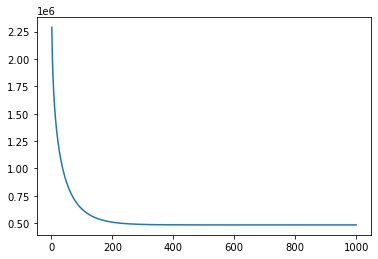

In [116]:
loss_trend = lr.loss_trend()
print(loss_trend[-5:])
print(lr.score(to_test_X.to_numpy(), to_test_Y['PM2.5'].to_numpy()))
plt.plot(np.arange(1, len(loss_trend)+1), loss_trend)

In [117]:
lr = []
score = []
loss_trend = []
weight = []
for i in range(4):
    all_ = list(range(4))
    all_.remove(i)
    to_train_X = pd.concat([trainX_set[all_[0]], trainX_set[all_[1]], trainX_set[all_[2]]])
    to_train_Y = pd.concat([trainY_set[all_[0]], trainY_set[all_[1]], trainY_set[all_[2]]])
    to_test_X = trainX_set[i].copy()
    to_test_Y = trainY_set[i].copy()
    
    lr.append(LinearRegression(max_iter=2000, eta0=1, learning_rate='Adagrad'))
    weight.append(lr[i].fit(to_train_X.to_numpy(), to_train_Y['PM2.5'].to_numpy()))
    loss_trend.append(lr[i].loss_trend())
    score.append(lr[i].score(to_test_X.to_numpy(), to_test_Y['PM2.5'].to_numpy()))

In [118]:
for i in range(4):
    print(loss_trend[i][-3:])
    print(score[i])

[441238.3965880618, 441238.39540664427, 441238.3942263212]
0.457814240681921
[503498.6625484746, 503498.64642311644, 503498.63030856784]
0.584164609229672
[502511.057457839, 502511.04712038103, 502511.03679258627]
0.6342577973816789
[483074.45699163375, 483074.44845133234, 483074.4399181738]
0.6273462687610472


In [105]:
weight

([array([20.95626154, -1.12410165,  0.85268153,  0.33279306, -1.41547425,
         -1.31604361,  2.36018875,  0.56553574,  2.36927989, 10.41812462,
         -0.27550511,  0.4074025 ,  0.18689799,  0.53152289, -0.43844372,
         -0.05494327, -2.39728314,  1.76544257]),
  array([21.64120644, -1.41616956,  0.30307411,  0.37706977, -1.03975861,
         -1.11558204,  3.0051404 , -0.81590947,  2.48985533, 10.80908089,
         -0.38575305,  0.65338338,  0.52677362,  0.22577477, -0.10853952,
         -0.06177905, -2.02491199,  1.2323865 ]),
  array([21.64072508, -1.47975825, -0.05328904,  0.49466904, -0.96045467,
         -1.92338987,  0.33450553,  1.8613394 ,  1.67404737, 10.90087962,
         -0.28030393, -0.04707439,  0.69785439,  0.66742517, -0.15549333,
         -0.15716511, -2.22148798,  1.63594543]),
  array([ 2.14707279e+01, -1.28790478e+00,  3.50127368e-01,  5.41051252e-01,
         -9.86250990e-01, -1.44035041e+00,  6.16050981e-01,  1.87649323e+00,
          2.30723741e+00,  1.0

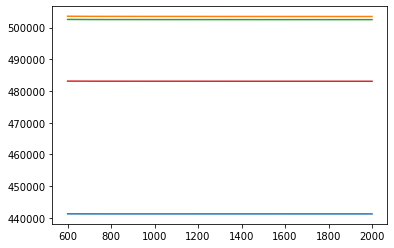

In [104]:
for i in range(4):
    plt.plot(np.arange(600, len(loss_trend[i])+1), loss_trend[i][599:])

In [39]:
train_X.drop(columns='day', inplace=True)

In [55]:
a = [1, 2, 3, 4]
a.remove(1)
print(a)

[2, 3, 4]
